# Micro Sim Video Model (U-Net)

## Imports

In [1]:
import os
import time
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass, asdict

from PIL import Image
from IPython import display
from IPython.display import Video
import matplotlib.pyplot as plt
import seaborn as sns
import moviepy.editor as mpy
from base64 import b64encode

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import resize

from diffusers import UNet2DModel, DDIMScheduler, get_cosine_schedule_with_warmup

import wandb

In [2]:
wandb.login()

wandb: Currently logged in as: parameterized. Use `wandb login --relogin` to force relogin


True

## Data processing and display setup

In [3]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['image.cmap'] = 'binary'
sns.set_theme(style='darkgrid')

def display_video(path, loop=True):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display.display(display.HTML(f'''<video src="{
        data_url}" controls=true autoplay=true {
        "loop=true " if loop else ""}/>'''))

In [4]:
# todo: compute actual mean/std
data_mean = np.full(3, .5)
data_std = np.full(3, .25)
print(data_mean, data_std)

# norm and inverse norm transformations
norm_t = transforms.Normalize(data_mean, data_std)
invnorm_t = transforms.Normalize(-data_mean / data_std, 1 / data_std)

tensor_to_img = lambda x: Image.fromarray(
    invnorm_t(x).clip(0, 1).movedim(-3, -1).detach().cpu()
    .multiply(255).type(torch.uint8).numpy())

[0.5 0.5 0.5] [0.25 0.25 0.25]


## Data and model configuration

In [5]:
@dataclass
class Config:
    # data
    frames_path: str = 'datasets/jams-germs/frames/Earthworm Under Microscope'
    frame_count: int = None
    frame_area: int = 910 * 512
    device: int = 'cuda'
    
    # model
    model_type: str = 'u-net'
    num_memory_feats: int = 2
    sample_size: int = 32
    img_shape: tuple = None
    layers_per_block = 2
    block_out_channels: tuple = (32, 64, 64)
    down_block_types: tuple = (
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    )
    up_block_types: tuple = (
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D"
    )
    
    # training
    load_pretrained: bool = False
    pretrained_path: str = 'models/VideoUNet_764687694'
    pool_size: int = 64
    batch_size: int = 16
    num_batch_frames: int = 4
    num_training_steps: int = int(2e3)
    lr: float = 1e-4
    num_warmup_steps: int = int(1e2)
    
    # noise scheduler
    noise_scheduler_type: str = 'DDIM'
    num_train_timesteps: int = 1000
    num_inference_steps: int = 64
    
    # automatically set these
    def init(self):
        self.frame_count: int = len(os.listdir(self.frames_path))
        self.img_shape = (3, self.sample_size, self.sample_size)
        return self

cf = Config().init()
asdict(cf)

{'frames_path': 'datasets/jams-germs/frames/Earthworm Under Microscope',
 'frame_count': 3909,
 'frame_area': 465920,
 'device': 'cuda',
 'model_type': 'u-net',
 'num_memory_feats': 2,
 'sample_size': 32,
 'img_shape': (3, 32, 32),
 'block_out_channels': (32, 64, 64),
 'down_block_types': ('DownBlock2D', 'AttnDownBlock2D', 'DownBlock2D'),
 'up_block_types': ('UpBlock2D', 'AttnUpBlock2D', 'UpBlock2D'),
 'load_pretrained': False,
 'pretrained_path': 'models/VideoUNet_764687694',
 'pool_size': 64,
 'batch_size': 16,
 'num_batch_frames': 4,
 'num_training_steps': 2000,
 'lr': 0.0001,
 'num_warmup_steps': 100,
 'noise_scheduler_type': 'DDIM',
 'num_train_timesteps': 1000,
 'num_inference_steps': 64}

## Data sampling utilities

In [6]:
def get_batch(batch_size=cf.batch_size, start_frames=None):
    """Get batch of size (batch_size, cf.num_batch_frames, *cf.img_shape)"""
    comp = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(512), # images are 910x512
        transforms.Resize(cf.sample_size)
    ])
    
    if start_frames is None:
        start_frames = np.random.randint(
            cf.frame_count - cf.num_batch_frames + 1, size=(batch_size,))
    
    batch = torch.empty(batch_size, cf.num_batch_frames, *cf.img_shape, device=cf.device)
    for i in range(batch_size):
        for j in range(cf.num_batch_frames):
            img = Image.open(f'{cf.frames_path}/{start_frames[i] + j}.jpg')
            batch[i, j] = norm_t(comp(img))
    
    return batch

In [7]:
class Pool():
    def __init__(self):
        """Create pool using cf config"""
        self.size = cf.pool_size
        self.start_frames = torch.randint(
            cf.frame_count - cf.num_batch_frames + 1, size=(self.size,))
        self.memory = torch.randn(
            self.size, cf.num_memory_feats, *cf.img_shape[1:], device=cf.device)
    
    def init(self, indices=None):
        """Re-initialize entire pool or at given indices"""
        if len(indices) == 0:
            return
        if indices is None:
            indices = torch.arange(self.size)
        
        self.start_frames[indices] = torch.randint(
            cf.frame_count - cf.num_batch_frames + 1, size=(len(indices),))
        self.memory[indices] = torch.randn(
            len(indices), cf.num_memory_feats, *cf.img_shape[1:], device=cf.device)
    
    def sample(self, indices):
        """
        Sample start_frames, memory at indices
        Returns: start_frames, memory
        """
        # replace 1/4 of batch with new samples
        self.init(indices[:len(indices) // 4])
        return self.start_frames[indices], self.memory[indices]
    
    def replace(self, indices, start_frames, memory):
        """Replace start_frames, memory at indices"""
        self.start_frames[indices] = start_frames + cf.num_batch_frames
        self.memory[indices] = memory
        # re-init if end reached
        self.init(indices[start_frames >= cf.frame_count - cf.num_batch_frames * 2])

## Make sure data sampling works

(-0.5, 137.5, 137.5, -0.5)

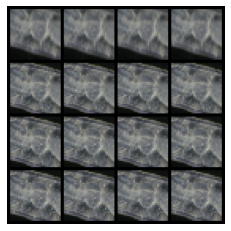

In [8]:
# test pool
tp = Pool()
full_clip = torch.empty(16, 3, 32, 32)
perm = torch.arange(1)
for i in range(4):
    start_frames, memory = tp.sample(perm)
    bx0s = get_batch(1, start_frames)
    full_clip[i*4:(i+1)*4] = bx0s[0][0]
    tp.replace(perm, start_frames, memory)

plt.imshow(torchvision.utils.make_grid(invnorm_t(full_clip), nrow=4)
         .permute(1, 2, 0).multiply(255).int().numpy())
plt.axis('off')

In [9]:
# (910*512)/(32*32) = 455 (full size patches)
def gen_trainset_video(path, fps=4):
    bx = get_batch(16)
    def make_frame(frame_state):
        if frame_state['first']:
            frame_state['first'] = False
            return np.zeros((512, 512, 3), dtype=np.int8)
        
        i = frame_state['i']
        frame = torchvision.utils.make_grid(invnorm_t(bx[:, i]), nrow=4)
        frame_state['i'] = min(i + 1, bx.shape[1] - 1)
        frame = resize(frame, 512).permute(1, 2, 0)
        return frame.clip(0, 1).multiply(255).int().cpu().numpy()
    
    os.makedirs(os.path.dirname(path), exist_ok=True)
    frame_state = {'i': 0, 'first': True}
    clip = mpy.VideoClip(lambda t: make_frame(frame_state),
                         duration=cf.num_batch_frames/fps)
    clip.write_videofile(path, fps=fps)
    return clip

clip = gen_trainset_video('output/trainset_video.mp4')
display_video('output/trainset_video.mp4', loop=True)

Moviepy - Building video output/trainset_video.mp4.
Moviepy - Writing video output/trainset_video.mp4



Moviepy - Done !
Moviepy - video ready output/trainset_video.mp4


## Define model

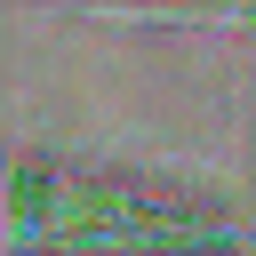

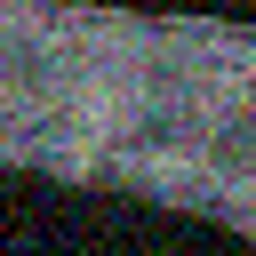

In [10]:
# test without memory
model = UNet2DModel(
    sample_size=cf.sample_size,
    in_channels=3,# + cf.num_memory_feats,
    out_channels=3,# + cf.num_memory_feats,
    layers_per_block=cf.layers_per_block,
    block_out_channels=cf.block_out_channels,
    down_block_types=cf.down_block_types,
    up_block_types=cf.up_block_types
).to(cf.device)

noise_scheduler = DDIMScheduler(num_train_timesteps=cf.num_train_timesteps)

opt = torch.optim.AdamW(model.parameters(), lr=cf.lr)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=opt,
    num_warmup_steps=cf.num_warmup_steps,
    num_training_steps=cf.num_training_steps
)
loss_fn = nn.MSELoss()
losses = []

pool = Pool()

x = get_batch(1)[:, 0]
# x = torch.cat([x, torch.randn(1, cf.num_memory_feats,
#     *cf.img_shape[1:], device=cf.device)], dim=1)
display.display(tensor_to_img(model(x, timestep=0)['sample'][0, :3]).resize((256, 256)))

noise = torch.randn_like(x)
timesteps = torch.tensor([100], dtype=torch.long, device=cf.device)
noisy_image = noise_scheduler.add_noise(x, noise, timesteps)
display.display(tensor_to_img(noisy_image[0, :3]).resize((256, 256)))

## Training

In [11]:
def get_pred_x0(x_t, t, pred_noise):
    alpha_prod_t = noise_scheduler.alphas_cumprod[t]
    beta_prod_t = 1 - alpha_prod_t
    return (x_t - beta_prod_t**.5 * pred_noise) / alpha_prod_t**.5

2,000 / 2,000
27m - eta 0s
lr: 0.00000000
loss: 0.07088528


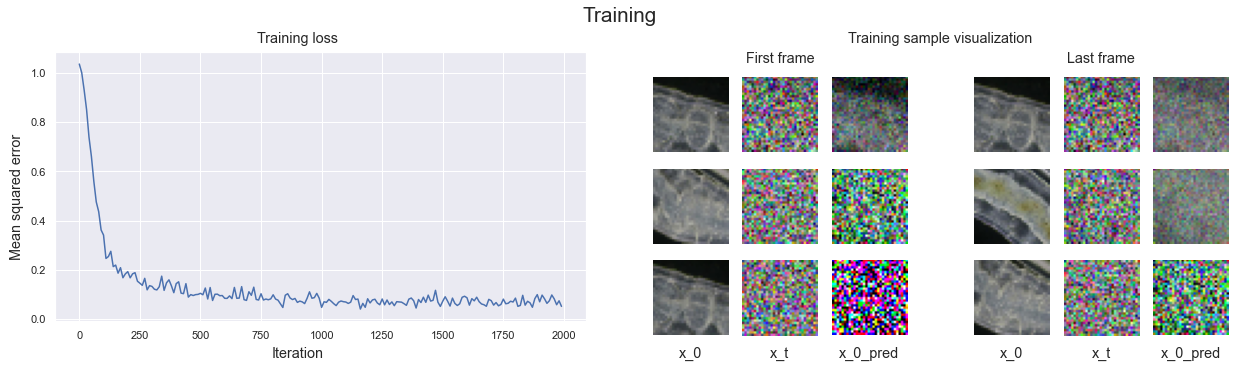

Saved to models/VideoUNet_122312957


In [12]:
loss_every_n = 10
display_every_n = 10

def train():
    model_id = f'{np.random.randint(1e9):09d}'
    model.train()
    
    run = wandb.init(
        mode='disabled',
        project='FractalDN',
        config={
            'model_id': model_id,
            **asdict(cf)
        },
        save_code=True
    )
    wandb.define_metric('train/step')
    wandb.define_metric('train/*', step_metric='train/step')
    
    with run:
        print('Training...')
        train_st = time.time()
        time_to_s = lambda t: f'{int(t)}s' if t < 60 else f'{int(t / 60)}m'
        
        for i in range(cf.num_training_steps):
            perm = torch.randperm(pool.size)[:cf.batch_size]
            start_frames, memory = pool.sample(perm)
            
            x0 = get_batch(cf.batch_size, start_frames)
            timesteps = torch.randint(
                noise_scheduler.num_train_timesteps,
                size=(cf.batch_size, cf.num_batch_frames),
                dtype=torch.long, device=cf.device
            )
            noise = torch.randn(cf.batch_size, cf.num_batch_frames,
                3 + cf.num_memory_feats, *cf.img_shape[1:], device=cf.device)
            
            loss = 0
            for frame_id in range(cf.num_batch_frames):
                # predict noise
                # x0_mem = torch.cat([x0[:, frame_id], memory], dim=1)
                # xt = noise_scheduler.add_noise(x0_mem, noise, timesteps[:, frame_id])
                xt = noise_scheduler.add_noise(
                    x0[:, frame_id], noise[:, frame_id, :3], timesteps[:, frame_id]
                )
                noise_pred = model(xt, timesteps[:, frame_id])['sample']
                loss = loss + loss_fn(noise_pred[:, :3], noise[:, frame_id, :3])
                
                if frame_id == 0:
                    first_xt = xt
                    first_noise_preds = noise_pred
                
                # compute memory from x0
                # noise_pred_0 = model(x0_mem, timestep=0)['sample']
                # memory = noise_pred_0[:, 3:]
                memory = noise_pred[:, -2:]
            
            loss = loss / cf.num_batch_frames
            
            # opt step
            opt.zero_grad()
            loss.backward()
            opt.step()
            lr_scheduler.step()
            
            # update pool
            pool.replace(perm, start_frames, memory.detach().clone())
            
            # plot
            if (i + 1) % loss_every_n == 0:
                losses.append(loss.item())
                wandb.log({
                    'train/step': i + 1,
                    'train/loss': loss.item()
                })
            if (i + 1) % display_every_n == 0:
                display.clear_output(wait=True)
                print(f'{i + 1 :,} / {cf.num_training_steps:,}')
                time_passed = time.time() - train_st
                eta = time_passed * (cf.num_training_steps - i) / max(i, 1)
                print(f'{time_to_s(time_passed)} - eta {time_to_s(eta)}')
                print(f'lr: {opt.state_dict()["param_groups"][0]["lr"]:.8f}')
                print(f'loss: {np.mean(losses[-100:]):.8f}')
                
                fig = plt.figure(constrained_layout=True, figsize=(5 * 3.4, 5))
                fig.suptitle('Training', fontsize='xx-large')
                loss_fig, vis_fig = fig.subfigures(1, 2, wspace=.1)
                
                loss_fig.suptitle('Training loss')
                loss_fig.supxlabel('Iteration')
                loss_fig.supylabel('Mean squared error')
                
                vis_fig.suptitle('Training sample visualization')
                
                ax = loss_fig.gca()
                sns.lineplot(np.arange(len(losses)) * loss_every_n, losses, ax=ax)
                
                vis_first, vis_last = vis_fig.subfigures(1, 2, wspace=.1)
                vis_first.suptitle('First frame')
                vis_last.suptitle('Last frame')
                
                for vis in [vis_first, vis_last]:                
                    vis_col_figs = vis.subfigures(1, 3)
                    x0_axes, xt_axes, x0p_axes = [
                        v.subplots(3, 1) for v in vis_col_figs]
                    for f, label in zip(vis_col_figs, ['x_0', 'x_t', 'x_0_pred']):
                        f.supxlabel(label)
                    
                    if vis == vis_first:
                        vis_frame = 0
                        xt = first_xt
                        noise_preds = first_noise_preds
                    else:
                        vis_frame = -1
                    
                    # show random samples of low, mid, high ranges of t
                    t_sort = torch.argsort(timesteps[:, vis_frame])
                    for k in range(3):
                        row_id = t_sort[np.random.randint(
                            t_sort.shape[0] // 3 * k,
                            t_sort.shape[0] // 3 * (k + 1))]
                        
                        x0_axes[k].imshow(tensor_to_img(x0[row_id, vis_frame]))
                        x0_axes[k].axis('off')
                        
                        xt_rgb = xt[row_id, :3]
                        xt_axes[k].imshow(tensor_to_img(xt_rgb))
                        xt_axes[k].axis('off')
                        
                        t = timesteps[row_id, vis_frame]
                        pred_x0 = get_pred_x0(xt_rgb, t, noise_preds[row_id, :3])
                        x0p_axes[k].imshow(tensor_to_img(pred_x0))
                        x0p_axes[k].axis('off')
                
                plt.show()
        
        model_path = f'models/VideoUNet_{model_id}'
        model.save_pretrained(model_path)
        print(f'Saved to {model_path}')


if cf.load_pretrained:
    model = model.from_pretrained(cf.pretrained_path).to(cf.device)
    print(f'Loaded from {cf.pretrained_path}')
else:
    train()

## Sample from model

In [14]:
from tqdm import tqdm
tqdm._instances.clear()

model.eval()

noise_scheduler.set_timesteps(num_inference_steps=cf.num_inference_steps)

def gen_video(path, duration=2, fps=24):
    def make_frame(frame_state):
        with torch.no_grad():
            frame_imgs = torch.empty(4, 4, *cf.img_shape, device=cf.device)
            vis_id = 0
            
            xt = torch.randn(4, *cf.img_shape, device=cf.device)
            # load last memory if not first frame
            if frame_state.get('memory') is not None:
                memory = frame_state['memory']
            else:
                memory = torch.randn(4, cf.num_memory_feats,
                    *cf.img_shape[1:], device=cf.device)
            
            # reverse diffusion steps
            num_ts = len(noise_scheduler.timesteps)
            for i, t in enumerate(noise_scheduler.timesteps):
                # mem_noised = noise_scheduler.add_noise(
                #     memory, frame_state['memory_noise'], t
                # )
                # xt_mem = torch.cat([xt, mem_noised], dim=1)
                # noise_pred = model(xt_mem, t)['sample']
                noise_pred = model(xt, t)['sample']
                xt = noise_scheduler.step(noise_pred[:, :3], t, xt)['prev_sample']
                
                # show 4 of the diffusion steps
                if i / num_ts > (vis_id + 1) / 4 or t == 0:
                    frame_imgs[:, vis_id] = invnorm_t(xt)
                    vis_id += 1
            
            # use memory from final prediction
            frame_state['memory'] = noise_pred[:, 3:]
            
            #frame = torchvision.utils.make_grid(invnorm_t(bxt_rgbs[0][:, 3:]), nrow=round(vid_batch_size**.5))
            frame = torchvision.utils.make_grid(frame_imgs.view(-1, *frame_imgs.shape[2:]), nrow=4)
            frame = resize(frame, 512).permute(1, 2, 0)
            return frame.clip(0, 1).multiply(255).int().cpu().numpy()
    
    os.makedirs(os.path.dirname(path), exist_ok=True)
    frame_state = {
        'memory_noise': torch.randn(4, cf.num_memory_feats,
            *cf.img_shape[1:], device=cf.device)
    }
    clip = mpy.VideoClip(lambda t: make_frame(frame_state), duration=duration)
    clip.write_videofile(path, fps=fps)
    return clip

clip_name = 'VideoUNet_sample'
clip = gen_video(f'output/{clip_name}.mp4')
display_video(f'output/{clip_name}.mp4', loop=False)

Moviepy - Building video output/VideoUNet_sample.mp4.
Moviepy - Writing video output/VideoUNet_sample.mp4



Moviepy - Done !
Moviepy - video ready output/VideoUNet_sample.mp4


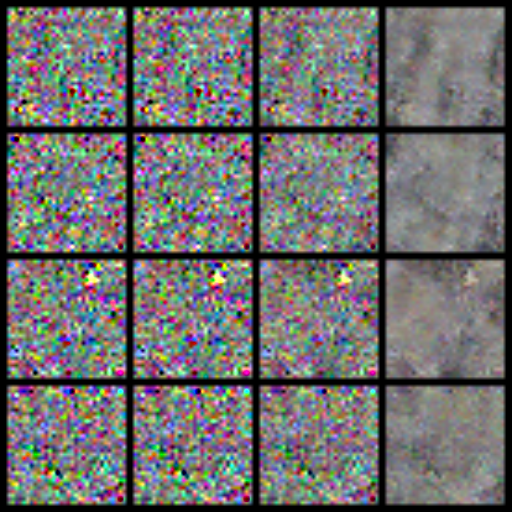

In [15]:
display.display(Image.fromarray(
    clip.get_frame(2).astype(np.uint8)
).resize((512, 512)))